In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import os

from matplotlib import cm
from matplotlib.lines import Line2D
plt.style.use("../paper.mplstyle")

## Plot the positions of all the OMs in the detector

We differentiate the DeepCore and main IceCube arrays by color. Furthermore, we apply a rotation in the $xy$-plane in order to maximize the minimum distance between the strings. We include three different functions for computing this minimum distance and compare their timing performance for personal edification.

In [2]:
GEOFILE = os.path.join(os.environ["I3_SRC"], "ppc", "resources", "ice", "geo-f2k")
DC_COLOR = "dodgerblue"
IC_COLOR = "crimson"

In [3]:
def parse_geofile(geofile: str) -> np.ndarray:
    xs = []
    ys = []
    zs = []
    colors = []

    positions = np.full((86, 60, 3), np.nan)
    is_dc = np.full((86, 60), False)

    with open(geofile) as f:
        for l in f:
            lsplit = l.replace("\n", "").split("\t")
            stringn = int(lsplit[5])
            omn = int(lsplit[6])

            if stringn < 1 or 86 < stringn or 60 < omn:
                continue

            if stringn > 78:
                is_dc[stringn-1, omn-1] = True
            x = float(lsplit[2])
            y = float(lsplit[3])
            z = float(lsplit[4])
            positions[stringn-1, omn-1, 0] = x
            positions[stringn-1, omn-1, 1] = y
            positions[stringn-1, omn-1, 2] = z
    return positions, is_dc

In [4]:
def rotate_positions(positions: np.ndarray, phi: float) -> np.ndarray:
    phi = np.random.uniform(0, np.pi)
    m = np.array([
        [np.cos(phi),  np.sin(phi), 0],
        [-np.sin(phi), np.cos(phi), 0],
        [0,           0,            1],
    ])

    new_positions = np.matmul(positions, m)
    return new_positions

In [5]:
def mindist1(meanx):
    distances = np.abs(meanx - np.expand_dims(meanx, axis=1))
    x = distances.flatten()
    x = x[x>0]
    mindistance = x.min()

    return mindistance

In [6]:
def mindist2(meanx):
    mindistance = np.inf
    for x1 in meanx:
        for x2 in meanx:
            if x1-x2==0:
                continue
            distance = np.abs(x1-x2)
            if distance < mindistance:
                mindistance = distance
    return mindistance

In [7]:
def mindist3(meanx):
    mindistance = np.inf
    for idx, x1 in enumerate(meanx):
        for jdx, x2 in enumerate(meanx):
            if idx>=jdx:
                continue
            distance = np.abs(x1-x2)
            if distance < mindistance:
                mindistance = distance
    return mindistance

In [8]:
def find_good_phi(positions, nshots=10_000, mindistf=mindist1):
    
    maxmindistance = 0
    best_phi = np.nan

    np.random.seed(2)

    for _ in range(nshots):

        phi = np.random.uniform(0, np.pi)
        new_positions = rotate_positions(positions, phi)
        meanx = np.mean(new_positions[:, :, 0], axis=1)
        mindistance = mindistf(meanx)
        if mindistance > maxmindistance:
            maxmindistance = mindistance
            best_phi = phi
            
    return best_phi

In [9]:
positions, is_dc = parse_geofile(GEOFILE)

In [10]:
%timeit find_good_phi(positions, nshots=100)

19.7 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit find_good_phi(positions, nshots=100, mindistf=mindist2)

1.94 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit find_good_phi(positions, nshots=100, mindistf=mindist3)

852 ms ± 8.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
phi = find_good_phi(positions)

In [14]:
def plot_detector(positions, is_dx, ax=None, phi=None, dc_color=DC_COLOR, ic_color=IC_COLOR):
    if phi is None:
        phi = find_good_phi(positions)
        
    plot_positions = rotate_positions(positions, phi)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5.27))

    ax.scatter(
        plot_positions[:, :, 0].flatten(),
        plot_positions[:, :, 2].flatten(),
        s=1.5,
        color=[dc_color if x else ic_color for x in is_dc.flatten()]
    )

    ax.set_ylim(-2483, -1400)
    ax.set_xlim(-623, 610)

    ax.set_ylabel(r"$z~\left[\mathrm{m}\right]$")
    ax.set_xlabel(r"$x~\left[\mathrm{m}\right]$")

    return ax

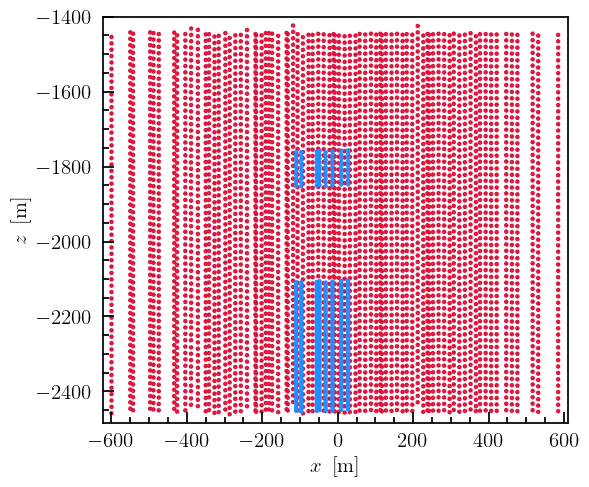

In [15]:
ax = plot_detector(positions, is_dc, phi=phi)
plt.show()

In [16]:
from solar_common.event_reader import event_reader_from_file, DataType, Selection

In [17]:
on_events = event_reader_from_file(
    "../../data/oscNext_data_new/oscNext_neutrino_simulation_no_muon.h5",
    Selection.OSCNEXT,
    DataType.MC
)

it_events = event_reader_from_file(
    "../../data/point_source_data/IC86_pass2_MC.npy",
    Selection.POINTSOURCE,
    DataType.MC
)

In [18]:
from matplotlib import colors

In [19]:
def plot_effective_area(hon, hit, ic_color=IC_COLOR, dc_color=DC_COLOR, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5.27))

    ax.fill_between(
        cents,
        hon / widths,
        (hit+hon) / widths,
        step="mid",
        facecolor=colors.to_rgb(ic_color),
        label="Main array"
    )
        
    ax.fill_between(
        cents,
        1e-8,
        hon / widths,
        step="mid",
        facecolor=colors.to_rgb(dc_color),
        label="DeepCore"
    )

    ax.step(
        cents, 
        (hit+hon) / widths,
        where="mid",
        color="k",
        label="Total"
    )

    ax.loglog()
    ax.legend()

    ax.set_xlim(2, 1e4)
    ax.set_ylim(1e-7, 3e1)
    
    ax.set_xlabel(r"$E_{\nu}~\left[\mathrm{GeV}\right]$")
    ax.set_ylabel(r"$A_{\mathrm{eff.}}~\left[\mathrm{m}^{2}\right]$")
    
    return ax

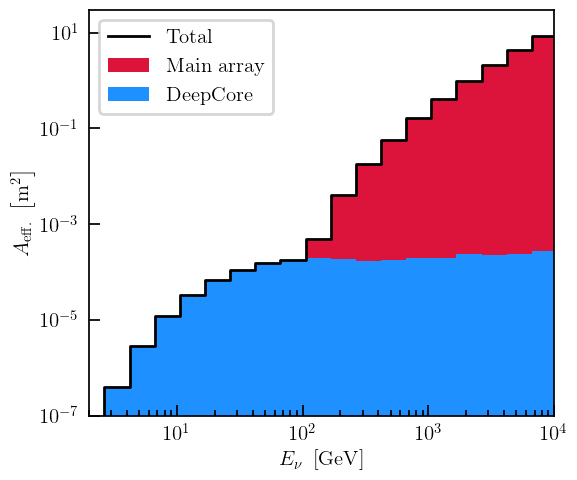

In [20]:
es = np.logspace(0, 6, 31)
cents = (es[1:] + es[:-1]) / 2
widths = es[1:] - es[:-1]

theta_min = np.pi / 2 - np.radians(23)
theta_max = np.pi / 2 + np.radians(23)

delta_omega = 2 * np.pi * (np.cos(theta_min) - np.cos(theta_max))

mask_on = np.logical_and(
    theta_min < on_events.true_zenith,
    on_events.true_zenith < theta_max
)

mask_it = np.logical_and(
    theta_min < it_events.true_zenith,
    it_events.true_zenith < theta_max
)

hon, _ = np.histogram(on_events.true_energy[mask_on], bins=es, weights=on_events.oneweight[mask_on])
hit, _ = np.histogram(it_events.true_energy[mask_it], bins=es, weights=it_events.oneweight[mask_it])

plot_effective_area(hon / delta_omega / 1e4, hit / delta_omega / 1e4)
plt.show()

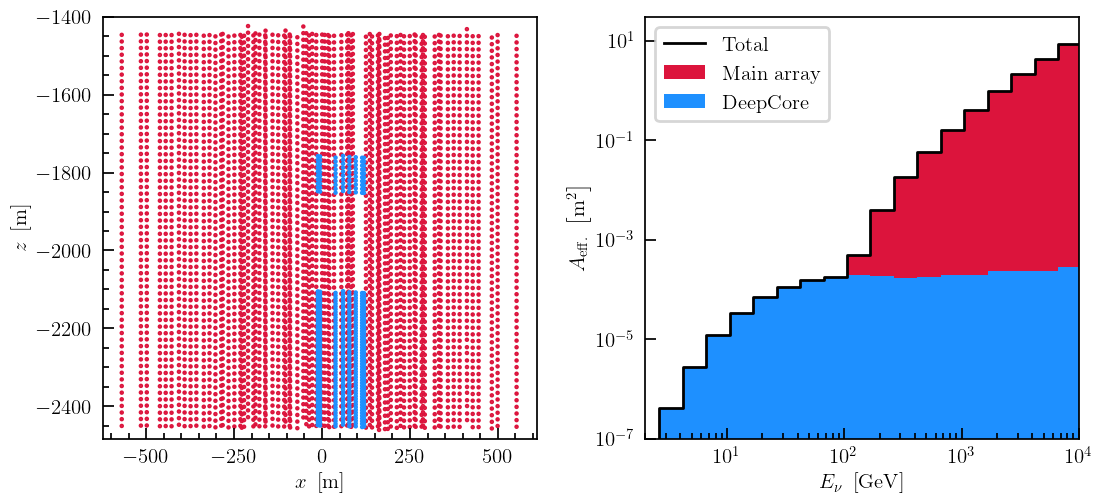

In [21]:
fig = plt.figure(figsize=(12.2, 5.27))

gs = fig.add_gridspec(1, 2,  width_ratios=(1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.25, hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_effective_area(hon / delta_omega / 1e4, hit / delta_omega / 1e4, ax=ax1)
plot_detector(positions, is_dc, phi=phi, ax=ax0)

plt.show()

## Now let's make a plot of the distribution of the signal events at production

In [22]:
def moving_average(a, n=6):
    ret = np.zeros(a.shape)
    for idx in range(len(ret)):
        if idx==0:
            ret[idx] = a[0]
            continue
        jdx = max(idx - n, 0)
#         print(idx, jdx)
#         print(len(a[jdx:idx]))
        ret[idx] = np.mean(a[jdx:idx])
    return ret

In [23]:
from matplotlib.lines import Line2D
from matplotlib import colors

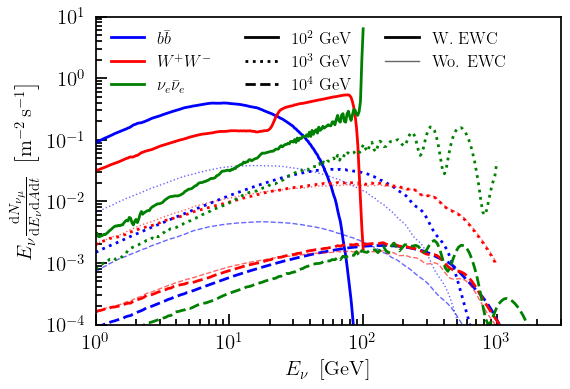

In [24]:
cs = ["blue", "red", "green"]

alpha = 0.6

handles = [
    Line2D([], [], label=r"$b\bar{b}$", color=cs[0]),
    Line2D([], [], label=r"$W^{+}W^{-}$", color=cs[1]),
    Line2D([], [], label=r"$\nu_{e}\bar{\nu}_{e}$", color=cs[2]),
    Line2D([], [], label=r"$10^{2}~\mathrm{GeV}$", color="k", ls="-"),
    Line2D([], [], label=r"$10^{3}~\mathrm{GeV}$", color="k", ls=":"),
    Line2D([], [], label=r"$10^{4}~\mathrm{GeV}$", color="k", ls="--"),
    Line2D([], [], label="W. EWC", color="k"),
    Line2D([], [], label="Wo. EWC", color=colors.to_rgb("k") + (alpha,), lw=1),
    Line2D([], [], alpha=0.0),
    
]

d = {
    "ewc": {},
    "no_ewc": {}
}

for channel in [5, 8, 12]:
    d["ewc"][channel] = {}
    d["no_ewc"][channel] = {}
    for mass in [100, 1000, 10000]:
        d["ewc"][channel][mass] = np.genfromtxt(f"../../data/tabulated_flux/{channel}-{mass}.txt")
        try:
            d["no_ewc"][channel][mass] = np.genfromtxt(f"../../data/tabulated_flux/{channel}-{mass}_pythia.txt")
        except:
            d["no_ewc"][channel][mass] = np.genfromtxt(f"../../data/tabulated_flux/{channel}-{mass}.txt")


_, ax = plt.subplots()

for channel, color in zip([5, 8, 12], cs):
    for mass, ls in zip([100, 1000, 10000], ["-", ":", "--"]):
        flux = d["ewc"][channel][mass]
        ax.plot(
            flux[:, 0],
            flux[:, 0] * moving_average(flux[:, 3]) * mass,
            color=color,
            ls=ls
        )
        
        if channel==12:
            continue
        
        flux = d["no_ewc"][channel][mass]
        ax.plot(
            flux[:, 0],
            flux[:, 0] * moving_average(flux[:, 3]) * mass,
            color=colors.to_rgb(color) + (alpha,),
            linestyle=ls,
            lw=1,
            alpha=0.6
        )

ax.set_ylim(1e-4, 10)
ax.set_xlim(1, 3e3)

ax.set_xlabel(r"$E_{\nu}~\left[\mathrm{GeV}\right]$")
ax.set_ylabel(r"$E_{\nu}\frac{\mathrm{d}N_{\nu_{\mu}}}{\mathrm{d}E_{\nu}\mathrm{d}A\mathrm{d}t}~\left[\mathrm{m}^{-2}\,\mathrm{s}^{-1}\right]$")

ax.legend(handles=handles, ncol=3, fontsize=12, frameon=False, loc=2)

ax.loglog()

plt.show()

## Make nominal signal and background distribution

In [25]:
from solar_common.utils import (
    oscnext_yearmaker,
    ps_yearmaker,
    prepare_data_distribution,
    prepare_simulation_distribution
)


In [26]:
oscnext_data_file = "/data/ana/BSM/IC86_all_energy_solar_WIMP/data/analysis_distributions/oscNext_data_scrambled_no_muon.h5"
oscnext_mc_file = "/data/ana/BSM/IC86_all_energy_solar_WIMP/data/analysis_distributions/oscNext_neutrino_simulation_no_muon_distributions.h5"
ps_data_file = "/data/ana/BSM/IC86_all_energy_solar_WIMP/data/analysis_distributions/ps_scrambled_data.h5"
ps_mc_file = "/data/ana/BSM/IC86_all_energy_solar_WIMP/data/analysis_distributions/IC86_pass2_MC_distributions.h5"
model = "5-200"

on_livetime = 308_056_760.53081256
it_livetime = 328673673.7984125

# Load up the simualtion
with h5.File(oscnext_mc_file, "r") as h5f:
    osc_nom_sig = on_livetime * prepare_simulation_distribution(h5f, model)
with h5.File(ps_mc_file, "r") as h5f:
    ps_nom_sig = it_livetime * prepare_simulation_distribution(h5f, model)
    
# Load up the scrambled data
with h5.File(oscnext_data_file, "r") as h5f:
    osc_nom_bg = prepare_data_distribution(h5f, oscnext_yearmaker)
with h5.File(ps_data_file, "r") as h5f:
    ps_nom_bg = prepare_data_distribution(h5f, ps_yearmaker)

# Load up the solar_

In [27]:
def make_signal_plot(osc_next_dist, pt_src_dist, ax=None, vmin=None, vmax=None, cax=None):
    
    if ax is None:
        _, ax = plt.subplots()

    z = (osc_next_dist.sum(axis=-1) + pt_src_dist).T[::-1]

    im = ax.imshow(
        np.log10(z),
        extent=[0, 180, -3, 6],
        aspect="auto",
        cmap="plasma",
        vmax=vmax,
        vmin=vmin,
    )

    ax.set_ylim(np.log10(5), np.log10(3e3))
    ax.set_xlim(0, 40)

    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels([r"$10^{1}$", r"$10^{2}$", r"$10^{3}$"])
    ax.set_ylabel(r"$E_{\mathrm{reco}}~\left[\mathrm{GeV}\right]$")

    ax.set_xlabel(r"$\psi~\left[^{\circ}\right]$")

    cbar = plt.colorbar(im, label=r"$N_{\mathrm{evts}}$", cax=cax)

    ax.text(16, np.log10(2100), r"$\chi\chi\rightarrow b\bar{b},~m_{\chi}=200\,\mathrm{GeV}$")
    ax.text(24, np.log10(1300), r"$\sigma_{\chi N}^{\mathrm{SD}}=10^{-40}\,\mathrm{cm}^2$")

    cbar.set_ticks([-4, -3, -2, -1])
    cbar.set_ticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

    return ax

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


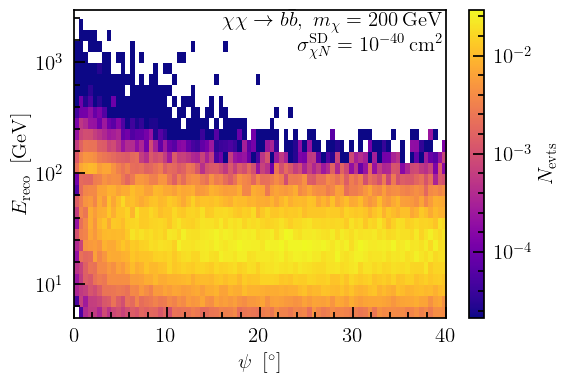

In [28]:
make_signal_plot(osc_nom_sig, ps_nom_sig, vmin=-4.67)
plt.show()

In [29]:
def make_background_plot(osc_next_dist, pt_src_dist, ax=None, vmin=None, vmax=None, cax=None):

    if ax is None:
        _, ax = plt.subplots()

    z = (osc_next_dist.sum(axis=-1) + pt_src_dist).T[::-1]

    im = ax.imshow(
        np.log10(z),
        extent=[0, 180, -3, 6],
        aspect="auto",
        cmap="viridis",
        vmax=vmax,
        vmin=vmin,
    )

    ax.set_ylim(np.log10(5), np.log10(3e3))
    ax.set_xlim(0, 40)

    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels([r"$10^{1}$", r"$10^{2}$", r"$10^{3}$"])
    ax.set_ylabel(r"$E_{\mathrm{reco}}~\left[\mathrm{GeV}\right]$")

    ax.set_xlabel(r"$\psi~\left[^{\circ}\right]$")

    cbar = plt.colorbar(im, label=r"$N_{\mathrm{evts}}$", cax=cax)

    cbar.set_ticks([-1, 0, 1, 2])
    # cbar.set_ticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"])
    cbar.set_ticklabels([r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"])

    return ax

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


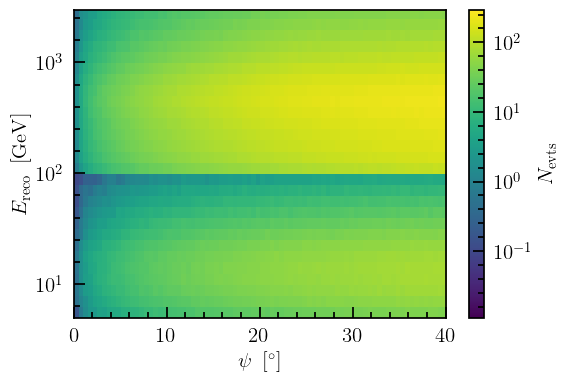

In [30]:
make_background_plot(osc_nom_bg, ps_nom_bg)
plt.show()

In [31]:
from matplotlib import gridspec

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


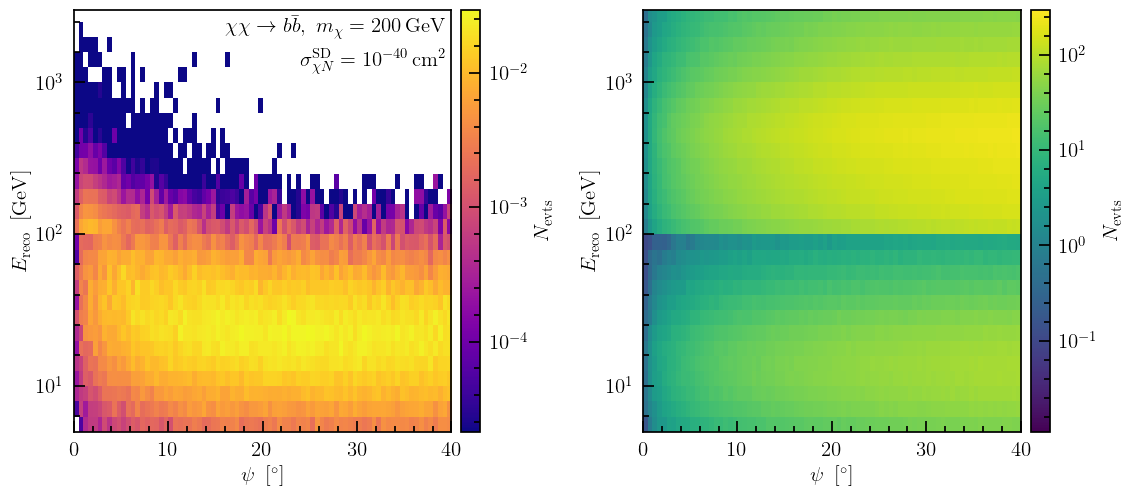

In [32]:
fig = plt.figure(figsize=(12.2, 5.27))

outer = fig.add_gridspec(1, 2,  width_ratios=(1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.4, hspace=0.05)

gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=outer[0], width_ratios=(6,0.3))
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, wspace=0.05, subplot_spec=outer[1], width_ratios=(6,0.3))
ax0 = fig.add_subplot(gs0[0])
cax0 = fig.add_subplot(gs0[1])
ax1 = fig.add_subplot(gs1[0])
cax1 = fig.add_subplot(gs1[1])

make_signal_plot(osc_nom_sig, ps_nom_sig, ax=ax0, vmin=-4.67, cax=cax0)
make_background_plot(osc_nom_bg, ps_nom_bg, ax=ax1, cax=cax1)

plt.show()

## Limits plot

In [33]:
style_dict = {
    "bb": "dotted",
    "ww": "dashed",
    "tt": "dashdot",
    "nuenue": (0, (3, 1, 1, 1)),
    "numunumu": (0, (5, 1)),
    "nutaunutau": (0, (3,3,1,3,1,3)),
}

sk_lims = {}
antares_lims = {}
for label in "bb ww tt".split():
    sk_lims[label] = np.genfromtxt(f"/data/user/jlazar/sk_limits_{label}.csv", delimiter=",")
    antares_lims[label] = np.genfromtxt(f"/data/user/jlazar/antares_limits_{label}.csv", delimiter=",")

pico_lims = np.genfromtxt("/data/user/jlazar/pico_limits.csv", delimiter=",")
lux_lims = np.genfromtxt("/data/user/jlazar/lux_limits.csv", delimiter=",")
xenon_lims = np.genfromtxt("/data/user/jlazar/xenon_limits.csv", delimiter=",")

x = np.load("/data/user/jlazar/lims.npy")
ms = [20, 50, 80, 100, 200, 500, 1000, 5000, 10000]
ic_lims = {
    "bb": np.array([ms, x[0]]).T,
    "ww": np.array([ms, x[1]]).T,
    "tt": np.array([ms, x[2]]).T,
    "nuenue": np.array([ms, x[3]]).T,
    "numunumu": np.array([ms, x[4]]).T,
    "nutaunutau": np.array([ms, x[5]]).T,
}

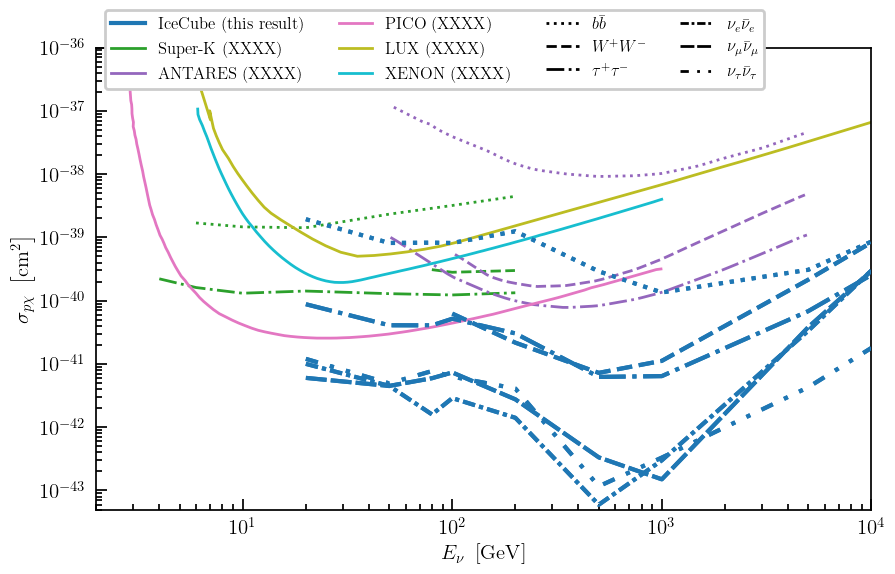

In [35]:
cmap = cm.get_cmap("tab10")

limits = [ic_lims, sk_lims, antares_lims, pico_lims, lux_lims, xenon_lims]

lw_ic = 3
lw_other = 2

handles = [
    Line2D([],[], color=cmap(0.0 / (len(limits)-1)), lw=lw_ic, label="IceCube (this result)"),
    Line2D([],[], color=cmap(1.0 / (len(limits)-1)), lw=lw_other, label="Super-K (XXXX)"),
    Line2D([],[], color=cmap(2.0 / (len(limits)-1)), lw=lw_other, label="ANTARES (XXXX)"),
    Line2D([],[], color=cmap(3.0 / (len(limits)-1)), lw=lw_other, label="PICO (XXXX)"),
    Line2D([],[], color=cmap(4.0 / (len(limits)-1)), lw=lw_other, label="LUX (XXXX)"),
    Line2D([],[], color=cmap(5.0 / (len(limits)-1)), lw=lw_other, label="XENON (XXXX)"),
    Line2D([],[], color="k", lw=lw_other, label=r"$b\bar{b}$", ls=style_dict["bb"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$W^{+}W^{-}$", ls=style_dict["ww"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\tau^{+}\tau^{-}$", ls=style_dict["tt"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{e}\bar{\nu}_{e}$", ls=style_dict["nuenue"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{\mu}\bar{\nu}_{\mu}$", ls=style_dict["numunumu"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{\tau}\bar{\nu}_{\tau}$", ls=style_dict["nutaunutau"]),
    
]


fig, ax = plt.subplots(figsize=(10, 6))

zorder = 10
lw = lw_ic

for idx, limit in enumerate(limits):
    color = cmap(idx / (len(limits)-1))
    
    if idx==0:
        for k, v in limit.items():
            ax.plot(v[:, 0], v[:, 1], ls=style_dict[k], c=color, zorder=10, lw=lw)
    
    if not isinstance(limit, dict):
        ax.plot(limit[:, 0], limit[:, 1], c=color, lw=lw)
    else:
        for k, v in limit.items():
            ax.plot(v[:, 0], v[:, 1], ls=style_dict[k], c=color, lw=lw)
    lw = lw_other
    zorder -= 1
        

ax.set_xlim(2, 1e4)
ax.set_ylim(5e-44, 1e-36)

ax.set_xlabel(r"$E_{\nu}~\left[\mathrm{GeV}\right]$")
ax.set_ylabel(r"$\sigma_{p\chi}~\left[\mathrm{cm^{2}}\right]$")

ax.loglog()

plt.legend(handles=handles, ncol=4, loc=2, bbox_to_anchor=(0,1.1), framealpha=1, fontsize=12)

plt.show()

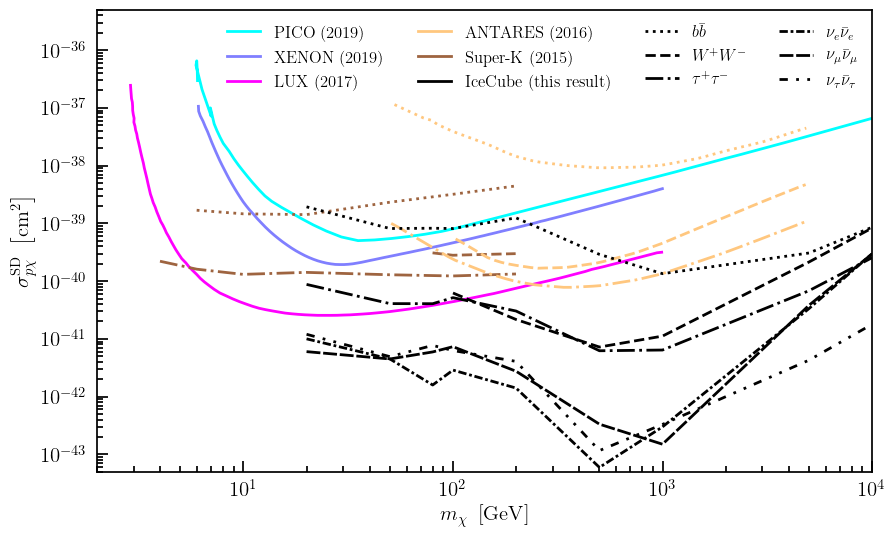

In [51]:
cmap1 = cm.get_cmap("copper")
cmap2 = cm.get_cmap("cool")

limits = [ic_lims, lux_lims, xenon_lims, pico_lims, sk_lims, antares_lims]

lw_ic = 2
lw_other = 2

handles = [
    Line2D([],[], color=cmap2(0.0 / (len(limits) - 4)), lw=lw_other, label="PICO (2019)"),
    Line2D([],[], color=cmap2(1.0 / (len(limits) - 4)), lw=lw_other, label="XENON (2019)"),
    Line2D([],[], color=cmap2(2.0 / (len(limits) - 4)), lw=lw_other, label="LUX (2017)"),
    Line2D([],[], color=cmap1(2.0 / 2), lw=lw_other, label="ANTARES (2016)"),
    Line2D([],[], color=cmap1(1.0 / 2), lw=lw_other, label="Super-K (2015)"),
    Line2D([],[], color=cmap1(0.0 / 2), lw=lw_ic, label="IceCube (this result)"),
    Line2D([],[], color="k", lw=lw_other, label=r"$b\bar{b}$", ls=style_dict["bb"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$W^{+}W^{-}$", ls=style_dict["ww"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\tau^{+}\tau^{-}$", ls=style_dict["tt"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{e}\bar{\nu}_{e}$", ls=style_dict["nuenue"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{\mu}\bar{\nu}_{\mu}$", ls=style_dict["numunumu"]),
    Line2D([],[], color="k", lw=lw_other, label=r"$\nu_{\tau}\bar{\nu}_{\tau}$", ls=style_dict["nutaunutau"])
]


fig, ax = plt.subplots(figsize=(10, 6))

zorder = 10
lw = lw_ic

ctr_1 = 0
ctr_2 = 0

for idx, limit in enumerate(limits):
    
    kwargs = {"lw": lw_other}
    if idx==0:
        kwargs["zorder"] = 10
        kwargs["lw"] = lw_ic
    
    if not isinstance(limit, dict):
        color = cmap2(ctr_2 / (len(limits) - 4))
        ax.plot(limit[:, 0], limit[:, 1], c=color, **kwargs)
        ctr_2 += 1
    else:
        for k, v in limit.items():
            color = cmap1(ctr_1 / 2)
            ax.plot(v[:, 0], v[:, 1], ls=style_dict[k], c=color, **kwargs)
        ctr_1 += 1
    lw = lw_other
    zorder -= 1
        

ax.set_xlim(2, 1e4)
ax.set_ylim(5e-44, 5e-36)

ax.set_xlabel(r"$m_{\chi}~\left[\mathrm{GeV}\right]$")
ax.set_ylabel(r"$\sigma_{p\chi}^{\mathrm{SD}}~\left[\mathrm{cm^{2}}\right]$")

ax.loglog()

plt.legend(
    handles=handles,
    ncol=4,
    loc=1,
#     bbox_to_anchor=(0,1.1),
    framealpha=0.0, 
    fontsize=12
)

plt.show()